## MNIST convolutional neural network

Adapted from [Tensorflows](https://www.tensorflow.org/tutorials/layers) own tutorial on CNNs.

In [1]:
import os, math, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from helpers import read_mnist, tf_show_graph

In [2]:
start_time = time.time()
mnist_path = 'C:/src/tf-playground/mnist'
tf_logs = 'C:/src/tf-playground/logs'

TRAIN_EPOCHS = 24
BATCH_SIZE = 3000 # train batch size
TEST_BATCHES = 2 # how many batches to split test data in
REPORT_INTERVAL = 200 # adjust by number of epochs/hw
PLOT_SIZE = (16.9, 5.915)

In [3]:
with tf.name_scope('X'):
    X = tf.placeholder(tf.float32, [None, 784])
with tf.name_scope('Y_'):
    Y_ = tf.placeholder(tf.float32, [None, 10])
with tf.name_scope('reshape'):
    X_image = tf.reshape(X, [-1, 28, 28, 1])
with tf.name_scope('conv1'):
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
    XW_conv1 = tf.nn.conv2d(X_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.nn.relu(XW_conv1 + b_conv1)
with tf.name_scope('pool1'):
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
with tf.name_scope('conv2'):
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
    hW_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.nn.relu(hW_conv2 + b_conv2)
with tf.name_scope('pool2'):
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
with tf.name_scope('fc1'):
    W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
with tf.name_scope('fc2'):
    W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [4]:
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_, logits=y_conv))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
with tf.name_scope('correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y_, 1))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
mnist = read_mnist(mnist_path, one_hot=True)
print('Training images: {}'.format(mnist.train.num_examples))
print('Test images: {}'.format(mnist.test.num_examples))

Extracting C:/src/tf-playground/mnist\train-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\train-labels-idx1-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-labels-idx1-ubyte.gz
Training images: 55000
Test images: 10000


Label(value='...')

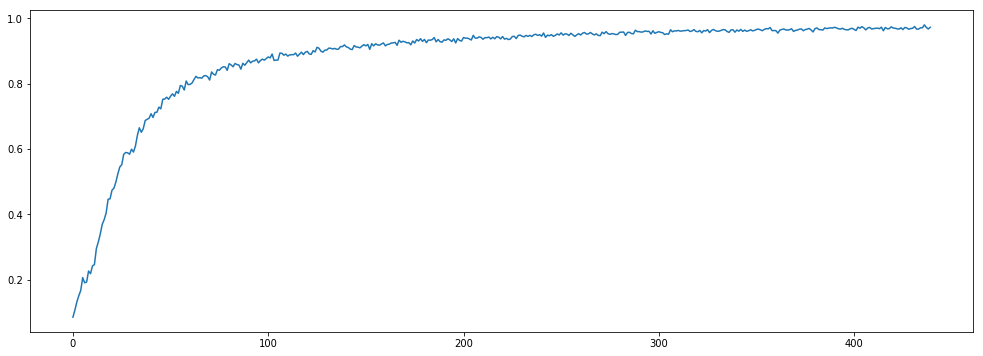

In [6]:
train_writer = tf.summary.FileWriter(tf_logs)
train_writer.add_graph(tf.get_default_graph())

loop_count = int(mnist.train.num_examples * TRAIN_EPOCHS / BATCH_SIZE)
report_mod = math.ceil(loop_count / REPORT_INTERVAL)

out_label = widgets.Label(value='...')
display(out_label)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
accuracies = []
for i in range(1, loop_count + 1):
    batch = mnist.train.next_batch(BATCH_SIZE)
    _, train_accuracy = sess.run([train_step, accuracy], feed_dict={X: batch[0], Y_: batch[1], keep_prob: 0.9})
    accuracies.append(train_accuracy)
    if i % report_mod == 0:
        progg = i / loop_count * 100
        ts = int(time.time() - start_time)
        ec = mnist.train.epochs_completed
        out_str = 'Data: {:.2f}%, accuracy: {:.2f}%, time: {}s, epochs completed: {}'
        out_label.value = out_str.format(progg, train_accuracy * 100, ts, ec)

ts = int(time.time() - start_time)
out_label.value = out_str.format(100, train_accuracy * 100, ts, mnist.train.epochs_completed)
plt.figure(figsize=PLOT_SIZE)
plt.plot(accuracies)
plt.show()

In [7]:
test_batch_size = int(mnist.test.num_examples / TEST_BATCHES)
test_accs = []
for i in range(0, TEST_BATCHES):
    test_batch = mnist.test.next_batch(test_batch_size)
    test_acc = sess.run(accuracy, feed_dict={X: test_batch[0], Y_: test_batch[1], keep_prob: 1.0})
    test_accs.append(test_acc)

print('Test accuracy: {:2.2f}%, epochs completed: {}'.format(np.mean(test_accs) * 100, mnist.test.epochs_completed))

Test accuracy: 97.56%, epochs completed: 0
